<p style="font-size: 40px; font-weight: bold; text-align: center;">Water pump maintenance - break prediction</p>

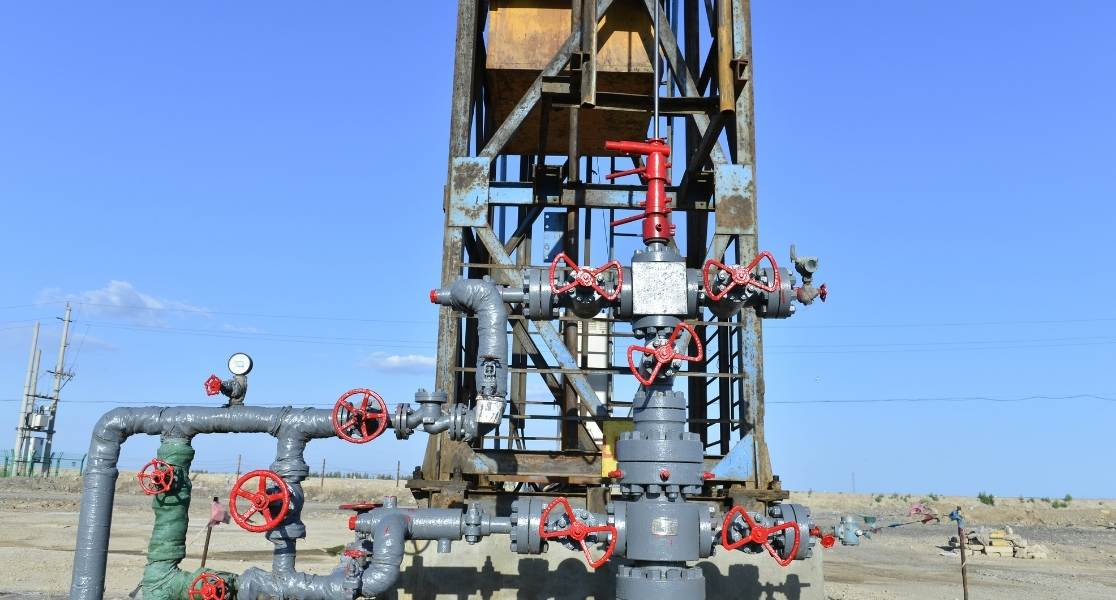

- <b>What is an industrial pump?</b>

    - An industrial pump is a robust and powerful pump that is used to transfer different materials such as water, chemicals, fuel, wastewater, sludge, or slurry. The most commonly used pumps in the industrial sector are centrifugal pumps and positive displacement pumps.

- <b>What leads to the failure of industrial pumps?</b>

    - Although user error is often blamed for pump failures, there are numerous other factors that contribute to it. Treating centrifugal and positive-displacement pumps alike can result in problems over time, as each type of pump requires a different approach. Improper operation speeds, misalignment, an incorrect size for the application, and contaminated lubricant are just some of the common issues that can lead to pump failure.

## Libraries

In [1]:
# Data Serialization
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
from sklearn.model_selection import train_test_split

# Data manipulation and computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from numpy.random import randint as rd

# Model evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score
)

from scikeras.wrappers import KerasClassifier

# Callback functions
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
)

# Import Pipeline and ColumnTransformer from sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Import various feature engineering and preprocessing tools
from feature_engine import imputation as im
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Import various classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier
)
from xgboost import XGBClassifier
from sklearn.svm import SVC
from mlens.ensemble import SuperLearner

# Import various evaluation metrics
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

# Import optimizers
from keras.optimizers import (
    Adam, 
    SGD, 
    RMSprop, 
    Adagrad, 
    Adadelta, 
    Adamax,
    Nadam
)

# Import libraries for building and training an ANN
import tensorflow
from keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2023-02-16 10:50:15.347441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[MLENS] backend: threading


## Functions

In [2]:
def sensor_status_plot(columns: list) -> None:
    """
    This function takes a list of sensor columns from a dataset and plots the sensor values over time,
    highlighting the periods where the machine status is recovering or broken.

    Parameters:
        columns (list): A list of sensor column names.

    Returns:
        None: The function only produces a plot.

    """
    # Loop over each sensor in the list of columns
    for sensor in columns:
        # Create a figure with a specific size
        plt.figure(figsize=(30,3))
        
        # Plot the sensor values during the recovering period
        plt.plot(
            df[df['machine_status']=='RECOVERING'][sensor], 
            linestyle='none', 
            marker='o', 
            color='yellow', 
            markersize=5,
            alpha=0.8
        )
        
        # Plot the sensor values over time
        plt.plot(
            df[sensor], 
            color='blue',
            alpha = 0.2
        )
        
        # Plot the sensor values during the broken period
        plt.plot(
            df[df['machine_status']=='BROKEN'][sensor],
            linestyle='none', 
            marker='o', 
            color='red', 
            markersize=10
        )

        plt.title('Sensor number : '+sensor[-2:])
        plt.xlim((0,200000))
        plt.grid()
        plt.show()
    
    # Return None since the function only produces a plot
    return None


In [3]:
def dtype_info(data:pd.DataFrame()) -> None: 
    """
    This function takes a pandas DataFrame as input and prints information about 
    the data types of its columns. It creates a dictionary mapping each unique 
    data type to a list of column names with that data type and then prints 
    the number of columns and the list of column names for each data type.
    For the 'float64' data type, it prints only the first four 
    column names followed by 'etc...'.

    Parameters:
        - data: a pandas DataFrame for which to show dtype information

    Returns:
        - None (prints information to console)
    """
    type_dict = {}  
    for dtype in data.dtypes.unique():  
        type_dict[dtype] = [col for col in data.columns if data[col].dtype == dtype] 
    for i in type_dict:  
        if i != 'float64':
            print('{} number of cols : {}\n{}\n'.format(i,len(type_dict[i]),type_dict[i]))  
        else:
            print('{} number of cols : {}\n{} etc...\n'.format(i,len(type_dict[i]),type_dict[i][:4]))  
    return None


In [4]:
def status_chacker(data:pd.DataFrame(),start:int,stop:int) -> int: 
    '''
    This function checks if the machine status is "BROKEN" or "RECOVERING" 
    for a range of minutes in a pandas DataFrame. It takes as input the
    DataFrame containing the machine status data, a start minute, and
    an end minute.It returns 1 if the machine status is "BROKEN" or 
    "RECOVERING" for any minute in the range, and 0 otherwise.

    Parameters:
        - data: a pandas DataFrame containing the machine status data
        - start: an integer representing the starting minute of the range to check
        - stop: an integer representing the ending minute of the range to check

    Returns:
        - 1 if the machine status is "BROKEN" or "RECOVERING" for any minute in the range
        - 0 otherwise
    '''
    for minute in range(start,stop):
        machine_status = data[data.columns[-1]].iloc[minute]
        if machine_status in ["BROKEN",'RECOVERING']:
            return 1
    return 0

In [5]:
def create_model(
    units=200,  # Number of neurons in the first dense layer
    optimizer=Adam,  # The optimizer to use
    learning_rate=0.001,  # Learning rate for the optimizer
    dropout_rate=0.2,  # Dropout rate for the dropout layers
    batch_size=100,  # Number of samples per gradient update
    epochs=20  # Number of epochs to train the model
) -> 'model':
    
    # Define the model architecture
    model = Sequential()
    
    # Add the first dense layer with ReLU activation and input shape
    model.add(Dense(units, activation="relu", input_shape=(pairs[0][0].shape[0],)))
    model.add(Dropout(dropout_rate))
    
    # Add the second dense layer with ReLU activation and half as many
    model.add(Dense(int(units/2), activation="relu"))
    model.add(Dropout(dropout_rate))
    
    # Add the output layer with one neuron and sigmoid activation
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", 
        optimizer=optimizer(learning_rate=learning_rate), 
        metrics=["accuracy"]
    )

    return model

In [6]:
def registrate_score(
    container:dict(),
    grid_search:'Gridsearch_model',
    train:pd.DataFrame(),
    train_t:pd.DataFrame(),
    test:pd.Series(),
    test_t:pd.Series(),
    algorithm_name:str,
    model:'Model' = None,
) -> None:
    '''    
    This function is used to store the evaluation scores of different algorithms.
    It appends the following evaluation metrics for each algorithm:
        - algorithm name
        - training score (roc auc)
        - training precision score
        - testing score (roc auc)
        - testing precision score
        - best hyperparameters obtained through hyperparameter tuning

    Parameters:
        container (dict): The dictionary that stores the evaluation results of different algorithms
        grid_search (scikit-learn GridSearchCV object): The GridSearchCV object that contains the best hyperparameters for the algorithm
        model (keras.engine.sequential.Sequential) : The keras Sequantial 
        train (pandas DataFrame): The training set
        train_t (pandas Series): The target variable for the training set
        test (pandas DataFrame): The testing set
        test_t (pandas Series): The target variable for the testing set
        algorithm_name (str): The name of the algorithm

    Returns:
        None
    '''
    if type(grid_search) != Sequential:
        container['algorithm_name'].append(algorithm_name)
        container['train_score_roc_auc'].append(grid_search.score(train,train_t))
        container['test_score_roc_auc'].append(grid_search.score(test,test_t))
        container['train_precision_score'].append(precision_score(train_t,grid_search.predict(train)))
        container['test_precision_score'].append(precision_score(test_t,grid_search.predict(test)))
        container['best_params'].append(grid_search.best_params_)
    else :
        container['algorithm_name'].append(algorithm_name)
        container['train_score_roc_auc'].append(roc_auc_score(train_t,(model.predict(train) > 0.5)))
        container['test_score_roc_auc'].append(roc_auc_score(test_t,(model.predict(test) > 0.5)))
        container['train_precision_score'].append(precision_score(train_t,(model.predict(train) > 0.5)))
        container['test_precision_score'].append(precision_score(test_t,(model.predict(test) > 0.5)))
        container['best_params'].append(grid_search.best_params_)

    return None

In [7]:
def final_plot(container:dict()) -> None:
    '''
    Plots the train and test scores for each 
    algorithm based on the specified metrics.

    Args:
    - container: A dictionary of metrics and their scores for each algorithm.

    Returns:
    - None
    '''
    # Iterate through each metric in the container
    for metrics in container:
        plot_list = ['train','test']
        fig = plt.figure(figsize=(25,10))
        ax = fig.add_subplot(121)
        for i in range(2):
            if i == 1:
                ax = fig.add_subplot(122)

            # Plot the data for the current metric, sorting by train data and coloring test data red
            sns.barplot(
                data=pd.DataFrame(main_dict[metrics])[['algorithm','train','test']].sort_values(by='train',ascending=False),
                x = plot_list[1],
                y = 'algorithm',
                color='red',
                alpha = 1,
                ax=ax
            )

            # Overlay the plot with the data sorted by test data and coloring train data with a Set2 color palette
            sns.barplot(
                data=pd.DataFrame(main_dict[metrics])[['algorithm','train','test']].sort_values(by='train',ascending=False),
                x = plot_list[0],
                y = 'algorithm',
                palette='Set2',
                ax=ax
            )

            # Add a label to the plot showing the metric and the score
            ax.bar_label(
                ax.containers[1],
                fmt=metrics+' score : %.3f',
                label_type='center'
            )

            plot_list.reverse()
            plt.xticks(ticks=(np.arange(0,1.1,0.1)))
            plt.grid(axis='x')
            plt.ylabel(None)
            plt.title(metrics)
        # Show the final plot
        plt.show()

    return None

In [8]:
def eval_plot(scores:list, target:str)-> None:
    """
    Plot a barplot to compare train and test scores of algorithms
    
    Parameters:
        scores (dict): a dictionary that contains the scores and algorithm names
        target (str): the main target score to compare, either 'train_score' or 'test_score'
    
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(16,5))
    
    data = pd.DataFrame(scores).sort_values(by=target,ascending=False)
    
    # map target score to secondary target score
    score_map = {
        'train_score_roc_auc': 'test_score_roc_auc',
        'test_score_roc_auc': 'train_score_roc_auc',
        'train_precision_score': 'test_precision_score',
        'test_precision_score': 'train_precision_score'
    }
    sec_target = score_map[target]
    
    # plot the main target score
    sns.barplot(
        data=data, 
        x=target, 
        y='algorithm_name', 
        palette='Paired', 
        ax=ax
    )
    
    # plot the secondary target score
    sns.barplot(
        data=data,
        x=sec_target,
        y='algorithm_name',
        palette='Paired', 
        alpha=0.2,
        ax=ax
    )
    
    # set plot title and formatting
    plt.title(f'{target.capitalize().replace("_", " ")} Metric Plot', fontsize=20)
    plt.grid(axis='x')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.show()

## Import dataset

In [9]:
# import dataset
df = pd.read_csv('sensor_TP.csv')
df.timestamp = df.timestamp.apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M'))

## Data exploration 

In [10]:
# Observing datatypes in dataset
dtype_info(df)

int64 number of cols : 1
['Unnamed: 0']

datetime64[ns] number of cols : 1
['timestamp']

float64 number of cols : 52
['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03'] etc...

object number of cols : 1
['machine_status']



- <b>Conclusion</b>
    - Our dataset consists of 1 datetime feature, 52 float features, and a target feature called 'machine_status'.<br> Additionally, there is an unnamed column which simply counts the number of rows and will be removed from the dataset.

In [11]:
# Observing null records
pd.DataFrame(df.isnull().mean().sort_values(ascending=False)[:4],columns=['Null mean'])

,Null mean
sensor_15,1.000000
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333


In [12]:
'''
    Sensor 15 and sensor 50 will be removed from dataset by quantity of null values
    Feature 'Unnamed: 0' is repeat index, also can be removed
    Feature ['sensor_00', 'sensor_18'] have < 1 std, also can be removed
'''
drop_list = list(df.isnull().mean().sort_values(ascending=False)[:2].index)
drop_list.append('Unnamed: 0')
for i in df.describe().transpose()[df.describe().transpose()['std']<1].index:
    drop_list.append(i)
df.drop(
    columns=drop_list,
    inplace=True
)

In [13]:
# Looking at total quantity of observation per day
for month in df.timestamp.dt.month.unique():
    for day in df[df.timestamp.dt.month == month].timestamp.dt.day.unique()[0:1]:
        print('{} - {} : number of observation {}'.format(month , day , len(df[(df.timestamp.dt.month == month) & (df.timestamp.dt.day == day)])))

4 - 1 : number of observation 1440
5 - 1 : number of observation 1440
6 - 1 : number of observation 1440
7 - 1 : number of observation 1440
8 - 1 : number of observation 1440


- <b>Conclusion</b>
    - The code aims to examine our dataset for any omitted rows during the recording process. Our findings showed that the data in the dataset was captured every minute, with a total of 1440 rows per day. However, there may be instances where the data flow was disrupted, suggesting a malfunction in the recording sensor or a switched off pump.

In [14]:
# Looking at total quantity of month days and sum of observation per month
for month in df.timestamp.dt.month.unique():
    print('month number : {}\nnumber of days : {}\nnumber of observation per month : {}\n'.format(
        month,
        len(df[(df.timestamp.dt.month == month)].timestamp.dt.day.unique()),
        len(df[(df.timestamp.dt.month == month)]),
    ))

month number : 4
number of days : 30
number of observation per month : 43200

month number : 5
number of days : 31
number of observation per month : 44640

month number : 6
number of days : 30
number of observation per month : 43200

month number : 7
number of days : 31
number of observation per month : 44640

month number : 8
number of days : 31
number of observation per month : 44640



- <b>Conclusion</b>
    - In this code section, I am counting the number of rows recorded for each month and trying to locate any breaks in the data recordings within the dataset.

In [15]:
# Let's observe the days when the pump has been broken
broken_dict = {}
count = 0
for i in df[['timestamp','machine_status']][(df.machine_status == 'BROKEN') | (df.machine_status == 'RECOVERING')].index:    
    if df.iloc[i].machine_status == 'BROKEN':
        broken_dict[df.iloc[i].timestamp,i] = []

for i in broken_dict:
    for j in df.index[i[1]+1:]:
        if df.iloc[j].machine_status == 'RECOVERING':
            broken_dict[i].append(j)
        else:
            break

for i in broken_dict:
    print('Broken day : {}\nRECOVER time spent : {}\nRECOVER time spend in days : {}\n'.format(i[0],np.round((len(broken_dict[i])/60),2),np.round(((len(broken_dict[i])/60)/24),2)))    

Broken day : 2018-04-12 21:55:00
RECOVER time spent : 15.73
RECOVER time spend in days : 0.66

Broken day : 2018-04-18 00:30:00
RECOVER time spent : 51.83
RECOVER time spend in days : 2.16

Broken day : 2018-05-19 03:18:00
RECOVER time spent : 21.87
RECOVER time spend in days : 0.91

Broken day : 2018-05-25 00:30:00
RECOVER time spent : 10.08
RECOVER time spend in days : 0.42

Broken day : 2018-06-28 22:00:00
RECOVER time spent : 139.83
RECOVER time spend in days : 5.83

Broken day : 2018-07-08 00:11:00
RECOVER time spent : 0.68
RECOVER time spend in days : 0.03

Broken day : 2018-07-25 14:00:00
RECOVER time spent : 1.25
RECOVER time spend in days : 0.05



- <b>Conclusion</b>
    - In this context, we are looking for all occurrences of breakdowns in our dataset and evaluating the time taken to fix each one.

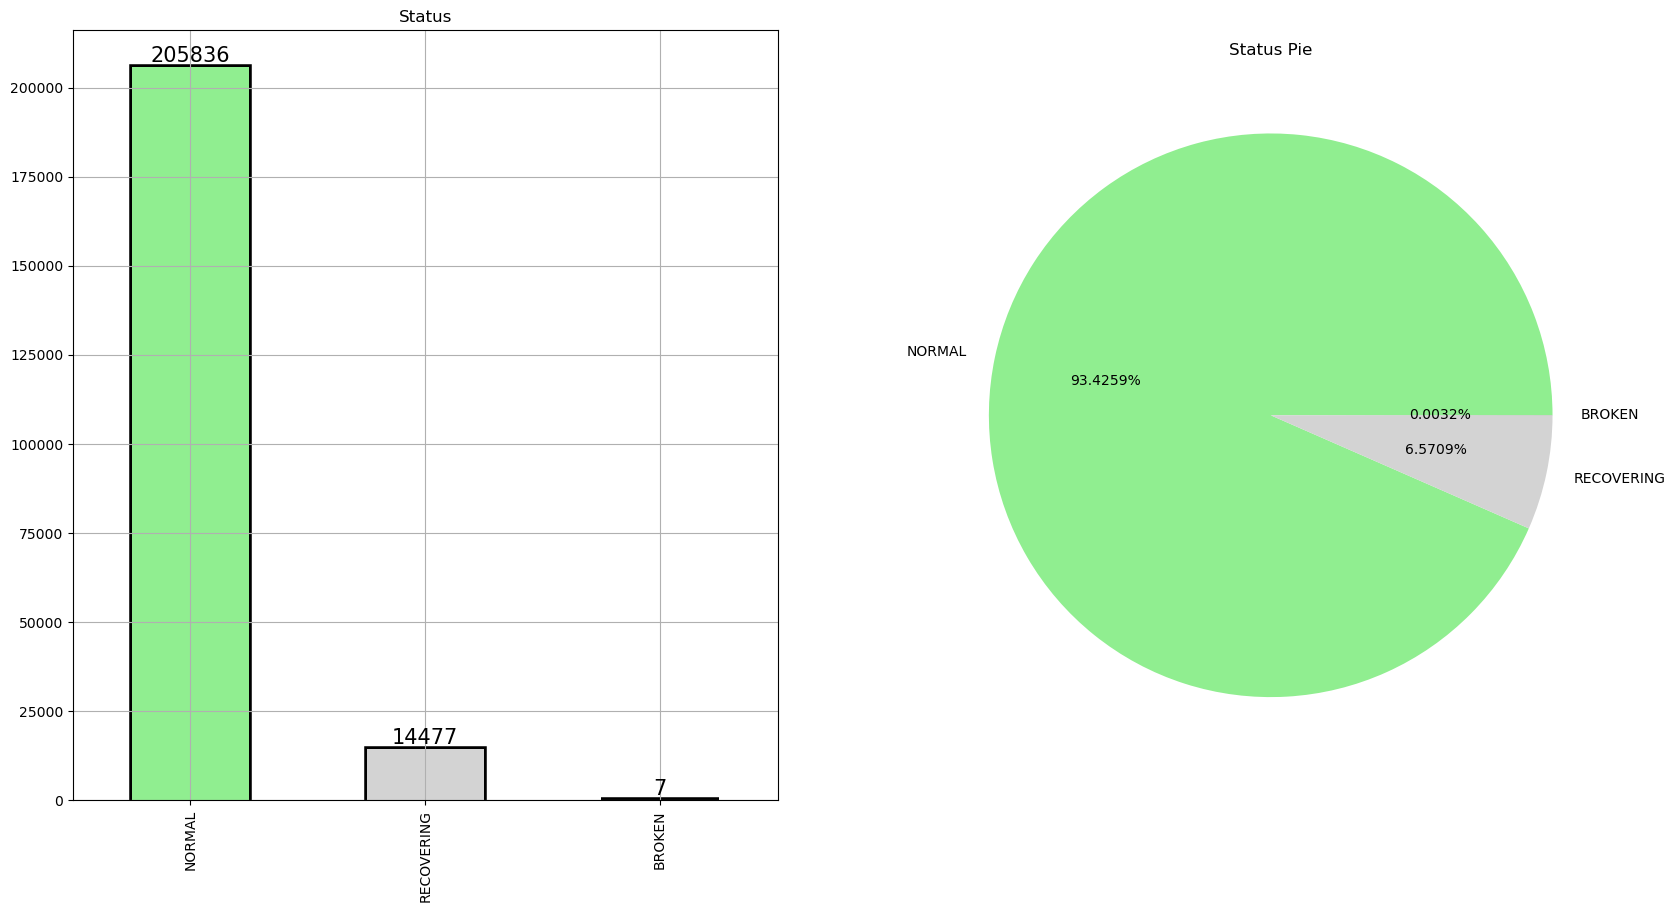

In [16]:
# Observing the overall distribution
color = [
    'lightgreen',
    'lightgray', 
    'black'
]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))

df.machine_status.value_counts().plot(
    kind='bar',
    ax=ax1, 
    color=color,
    edgecolor = 'black',
    linewidth=4
)

df.machine_status.value_counts().plot(
    kind='pie',
    ax=ax2, 
    autopct='%.4f%%', 
    colors=color
)

for bar in df.machine_status.value_counts().plot(kind='bar',ax=ax1,color=color).patches[:3]:
    ax1.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', 
                 va='center',
                 size=15, 
                 xytext=(0, 8),
                 textcoords='offset points'
                )

ax1.grid()
ax1.set_title('Status')
ax2.set_title('Status Pie')
ax2.set_ylabel('')
plt.show()

- <b>Conclusion</b>
    - On these graphs, we can visualize the level of unsteadiness in our dataset regarding pump malfunctions and normal functioning.

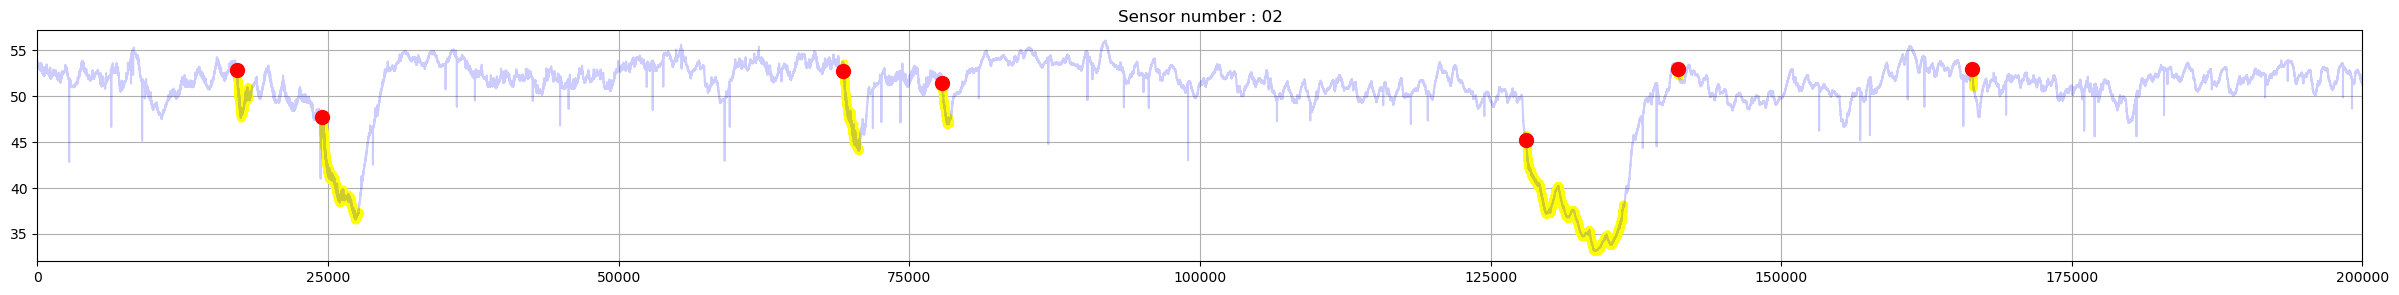

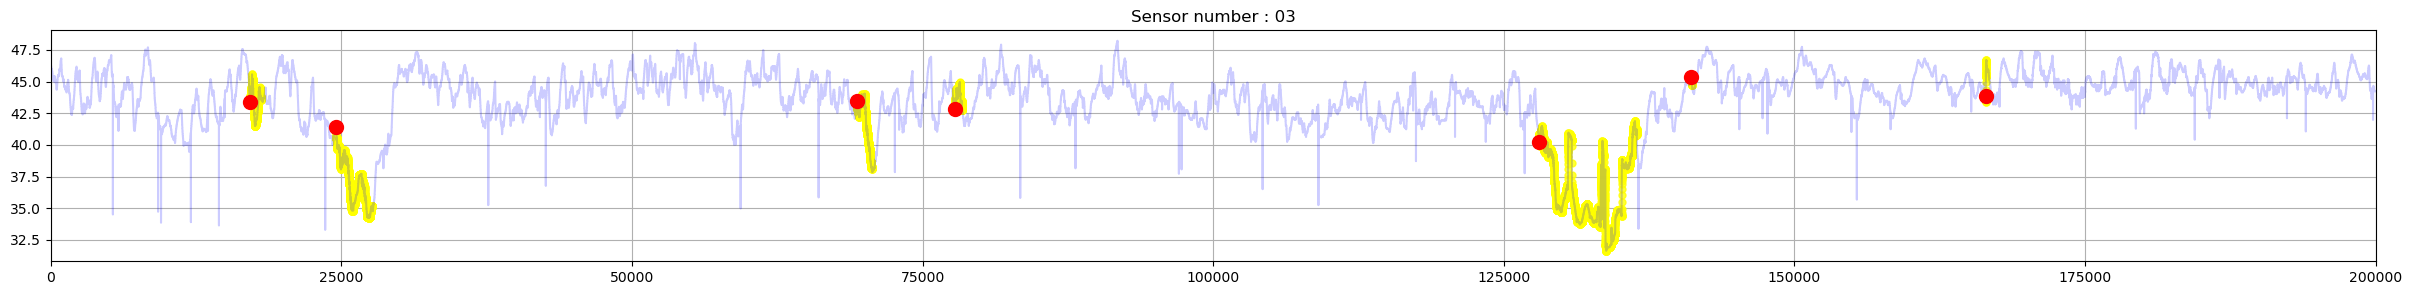

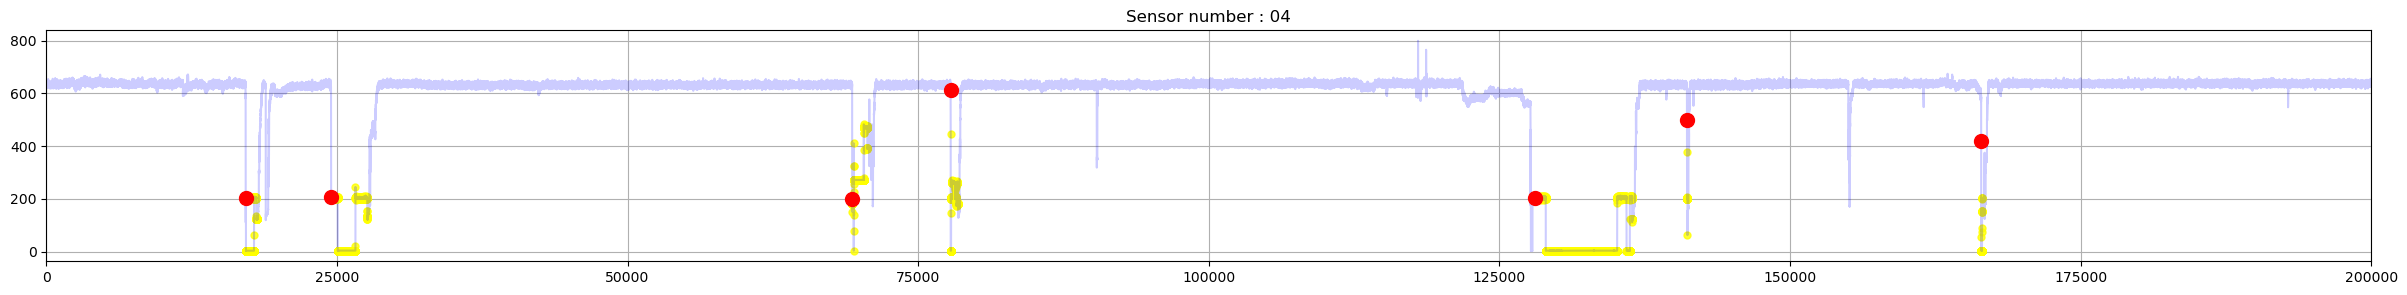

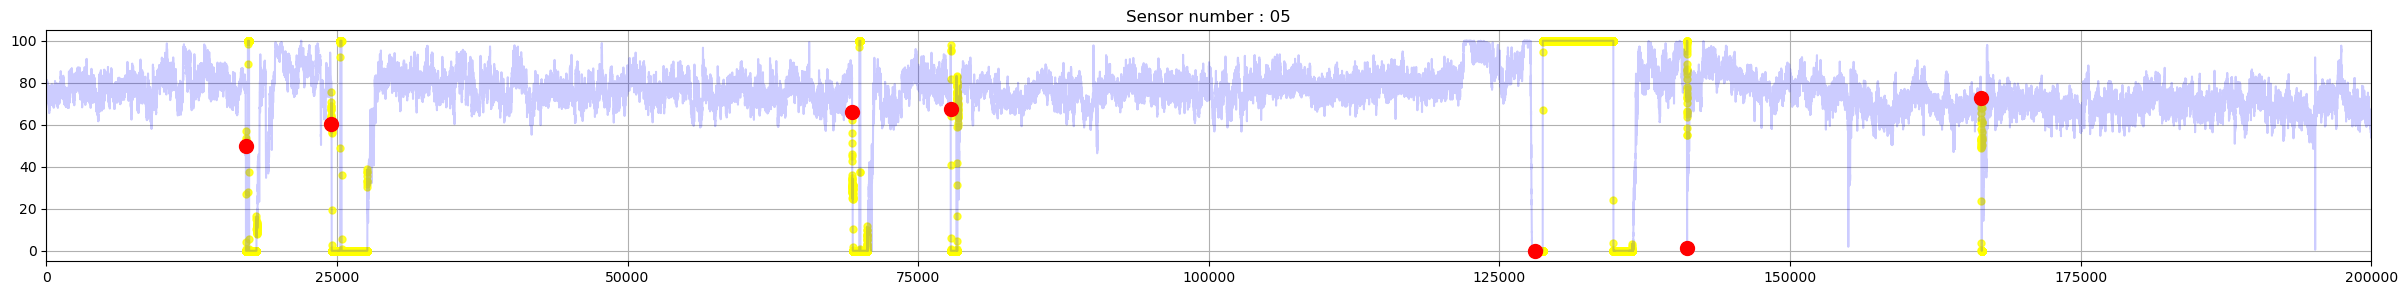

In [17]:
# Observing the sensors at the time of failure
sensor_status_plot(df.columns[2:6])

- <b>Conclusion</b>
    - On these charts, we see a pattern of the sensors consistently dropping during a malfunction.

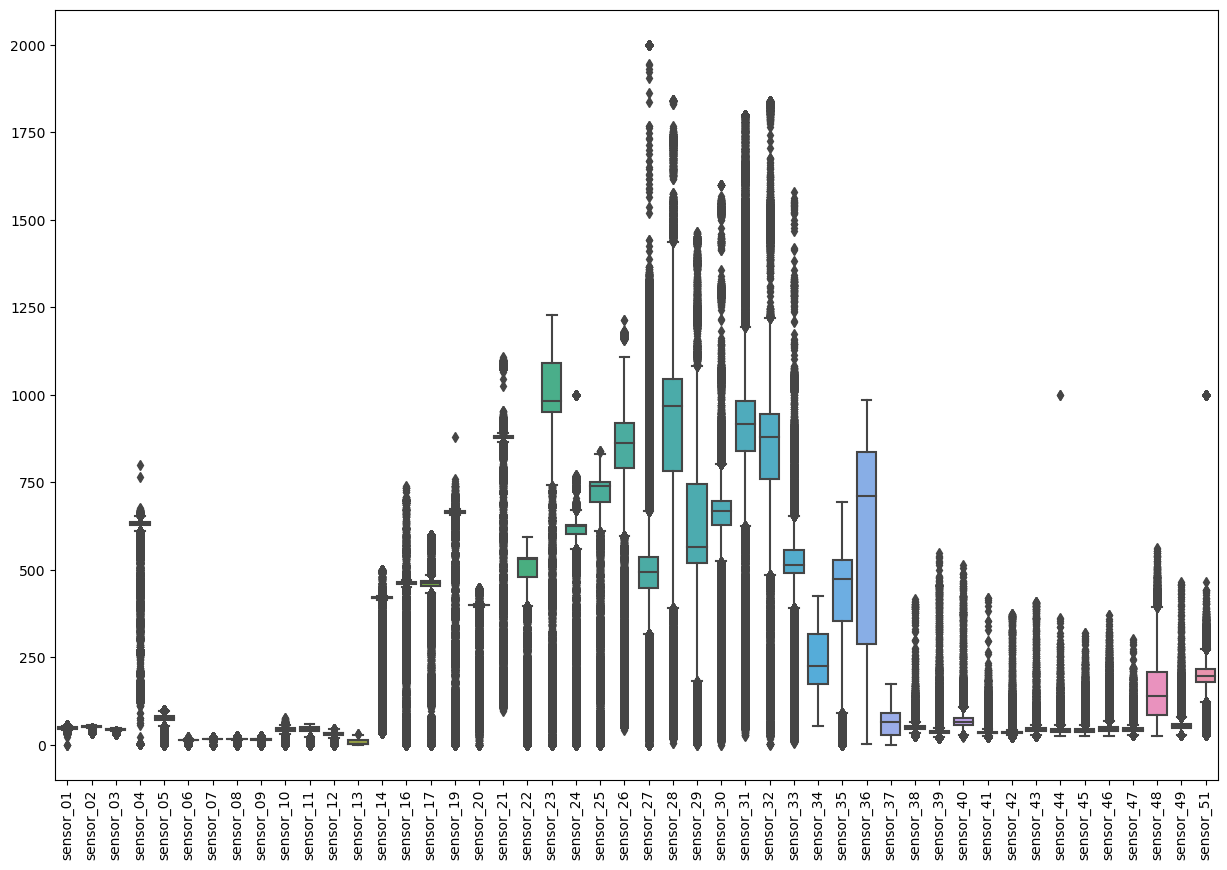

In [18]:
# Check outliers
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.xticks(rotation = 90)
plt.show()

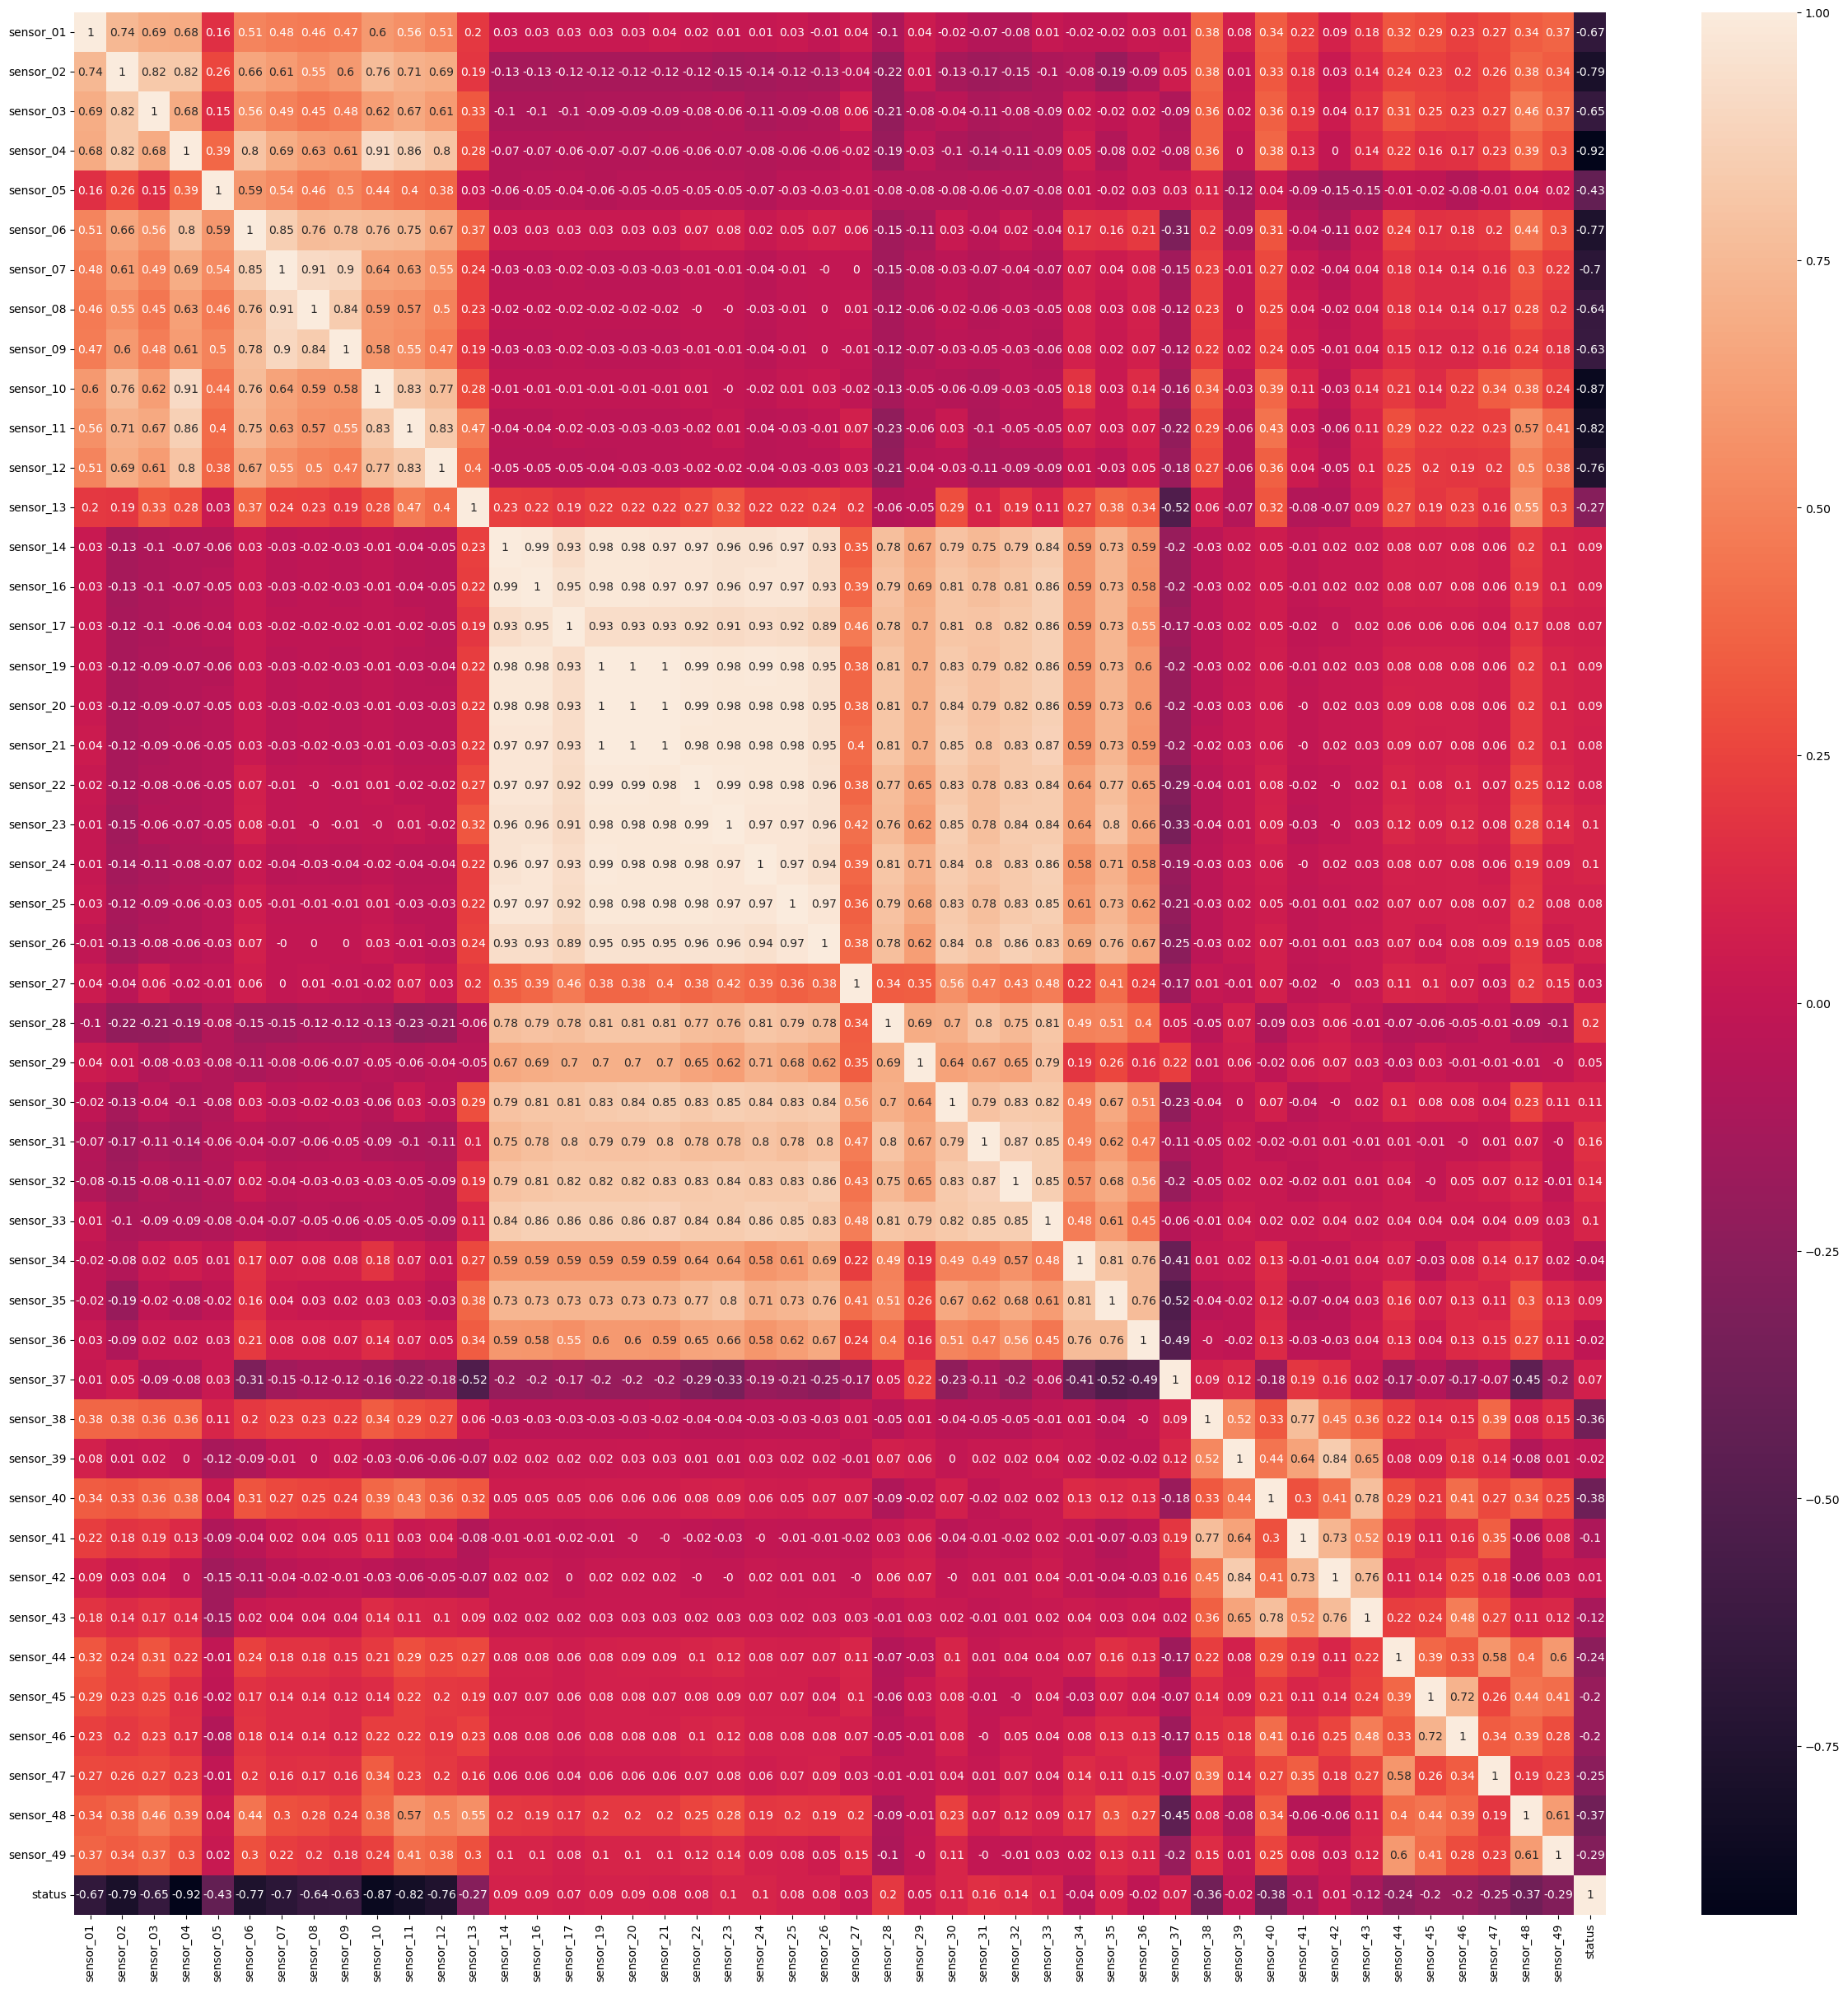

In [19]:
# Create a copy of the dataframe and map the machine status column to 0 for "NORMAL" and 1 for "BROKEN" and "RECOVERING"
df_corr = df.iloc[:, 1:-2].copy()
df_corr['status'] = df['machine_status'].map({'NORMAL': 0, 'BROKEN': 1, 'RECOVERING': 1})

# Plot the heatmap of correlations
plt.figure(figsize=(30,30))
sns.heatmap(
    df_corr.corr().round(2),
    annot=True
)
plt.show()

# Feature selection

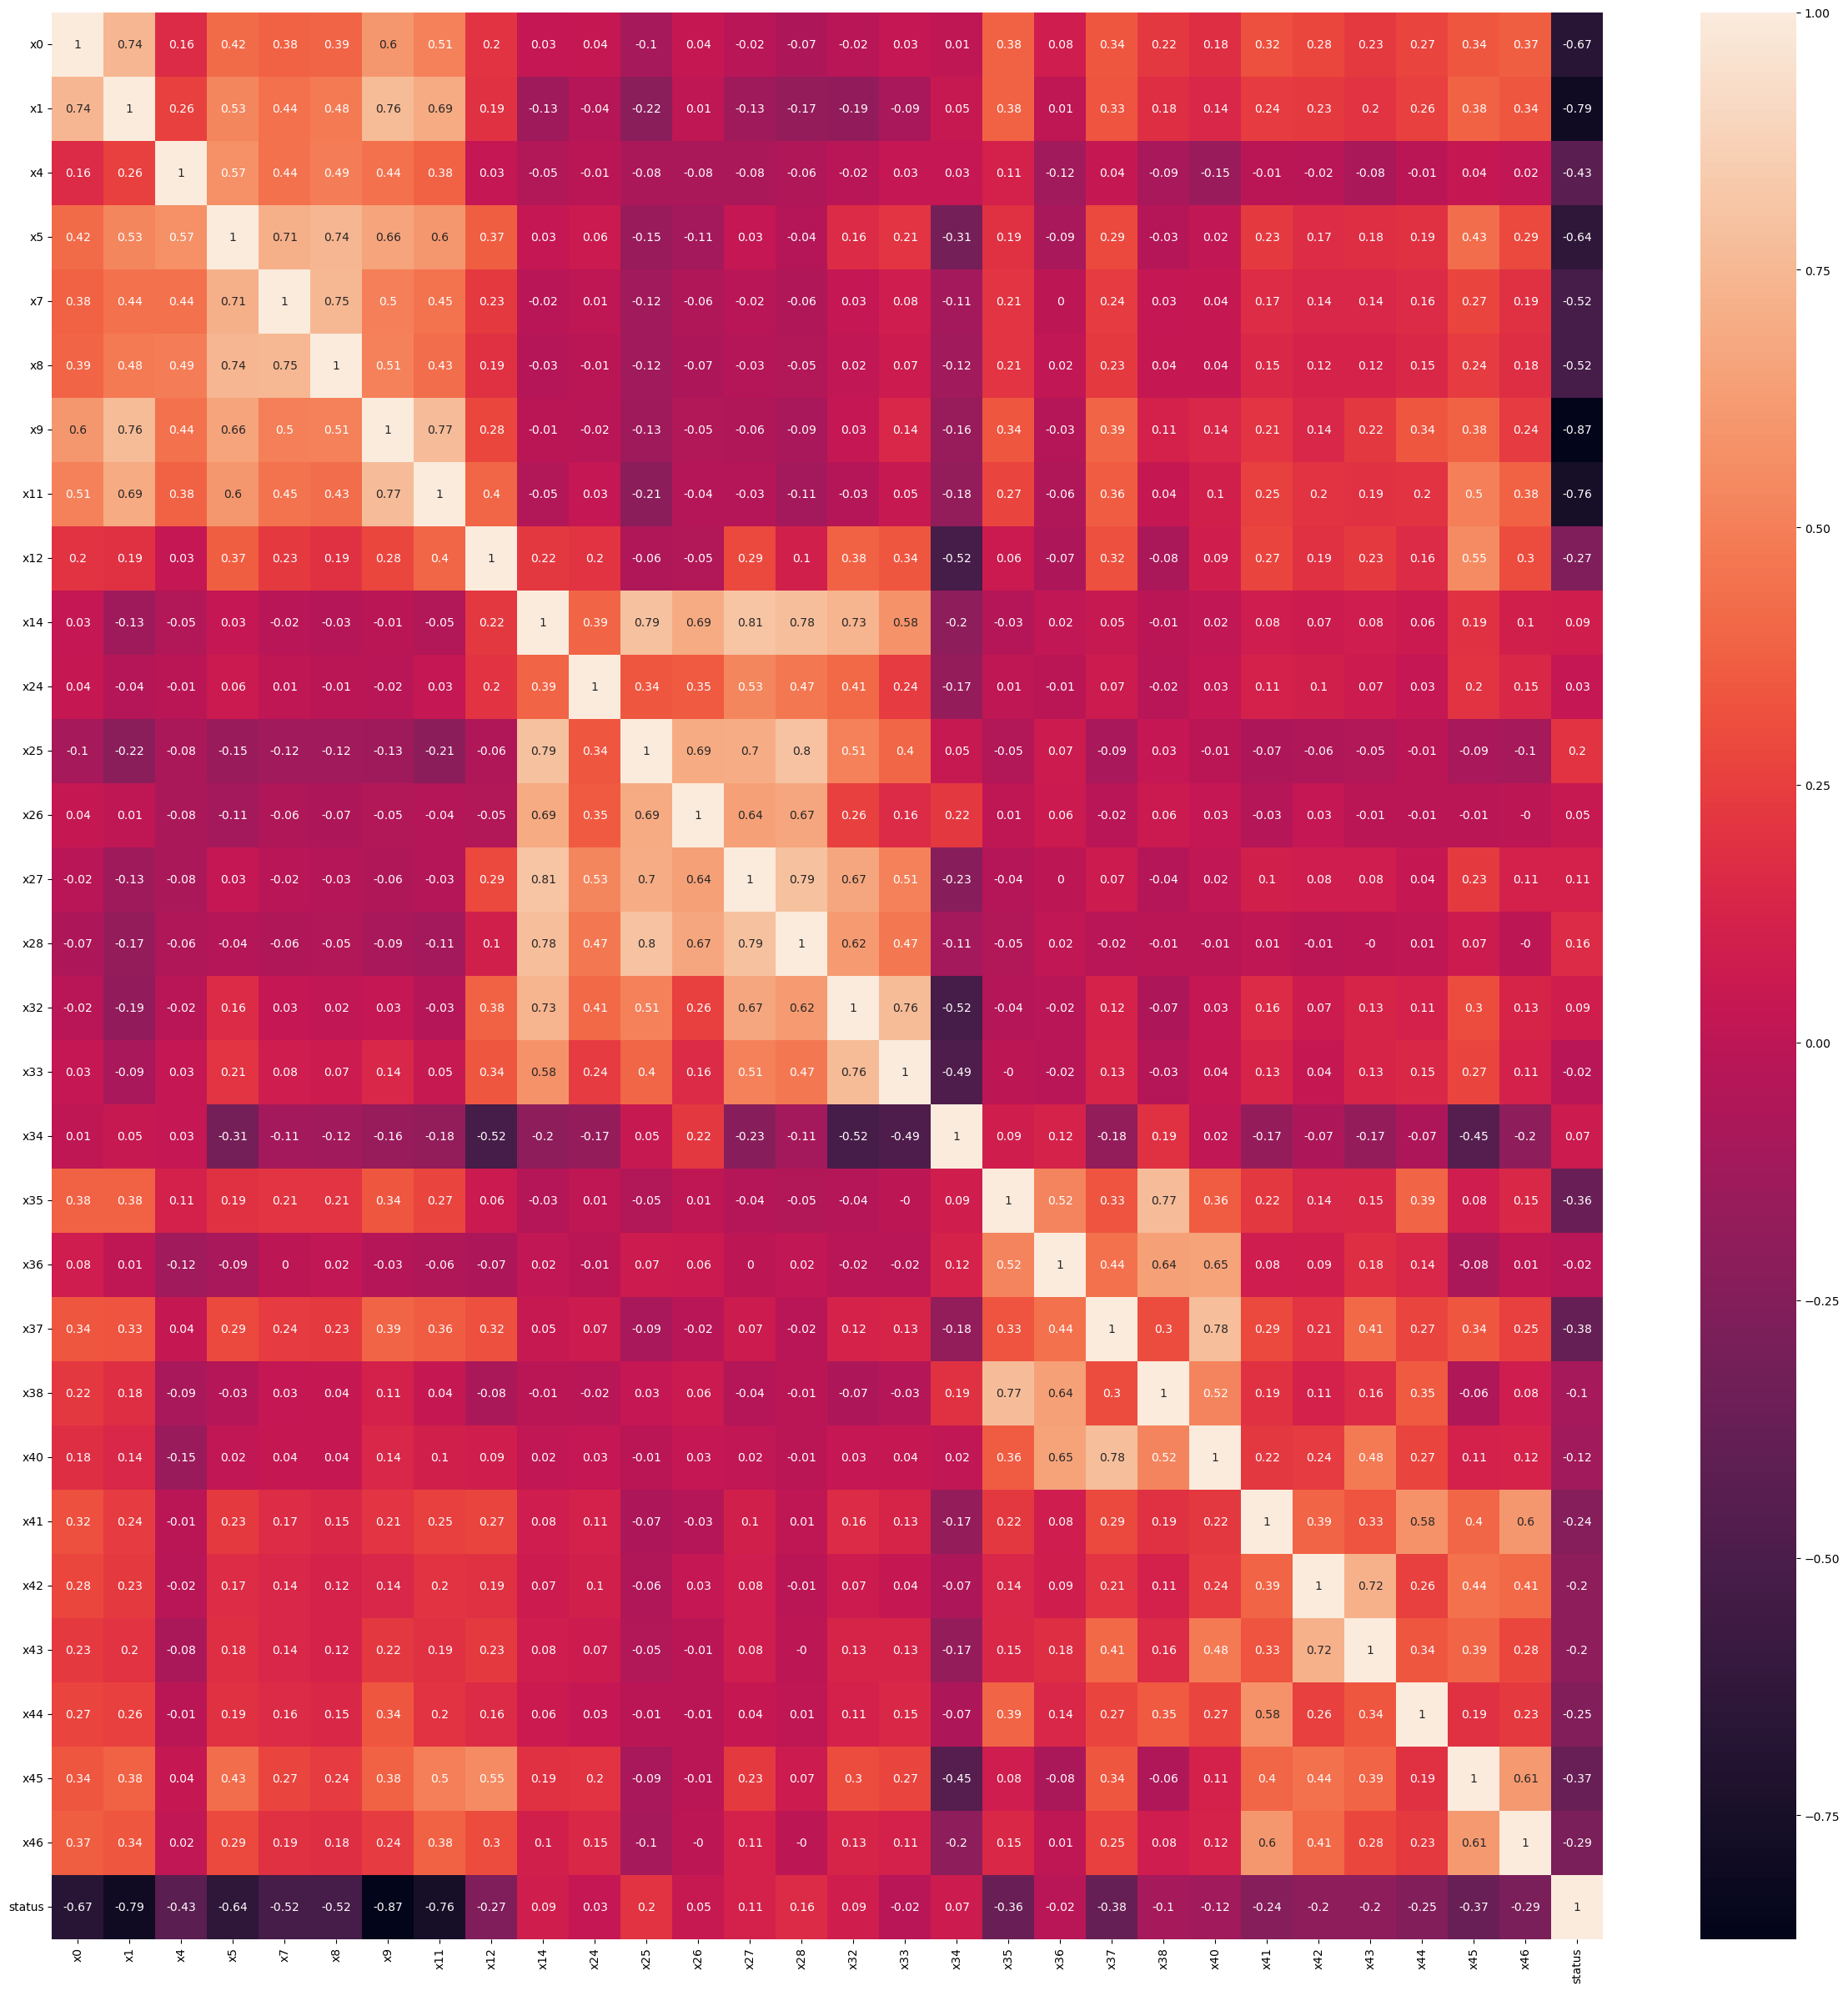

In [20]:
# Create a pipeline to drop constant and duplicate features and select correlated features
fs_pipe = Pipeline([
    ('drop_constant', DropConstantFeatures(tol=0.9)),
    ('drop_duplicate', DropDuplicateFeatures()),
    ('SmartCorrelatedSC', SmartCorrelatedSelection(method='pearson'))
])

# Fit the pipeline to the data, impute missing values, and add the target column
after_drop_df = fs_pipe.fit_transform(
    MinMaxScaler().fit_transform(im.MeanMedianImputer(imputation_method='mean').fit_transform(df_corr))
)
after_drop_df['status'] = df.machine_status.map({
    'NORMAL': 0,
    'BROKEN': 1,
    'RECOVERING': 1
})

# Plot a heatmap of the correlations between the features
plt.figure(figsize=(30,30))
sns.heatmap(after_drop_df.corr().round(2), annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

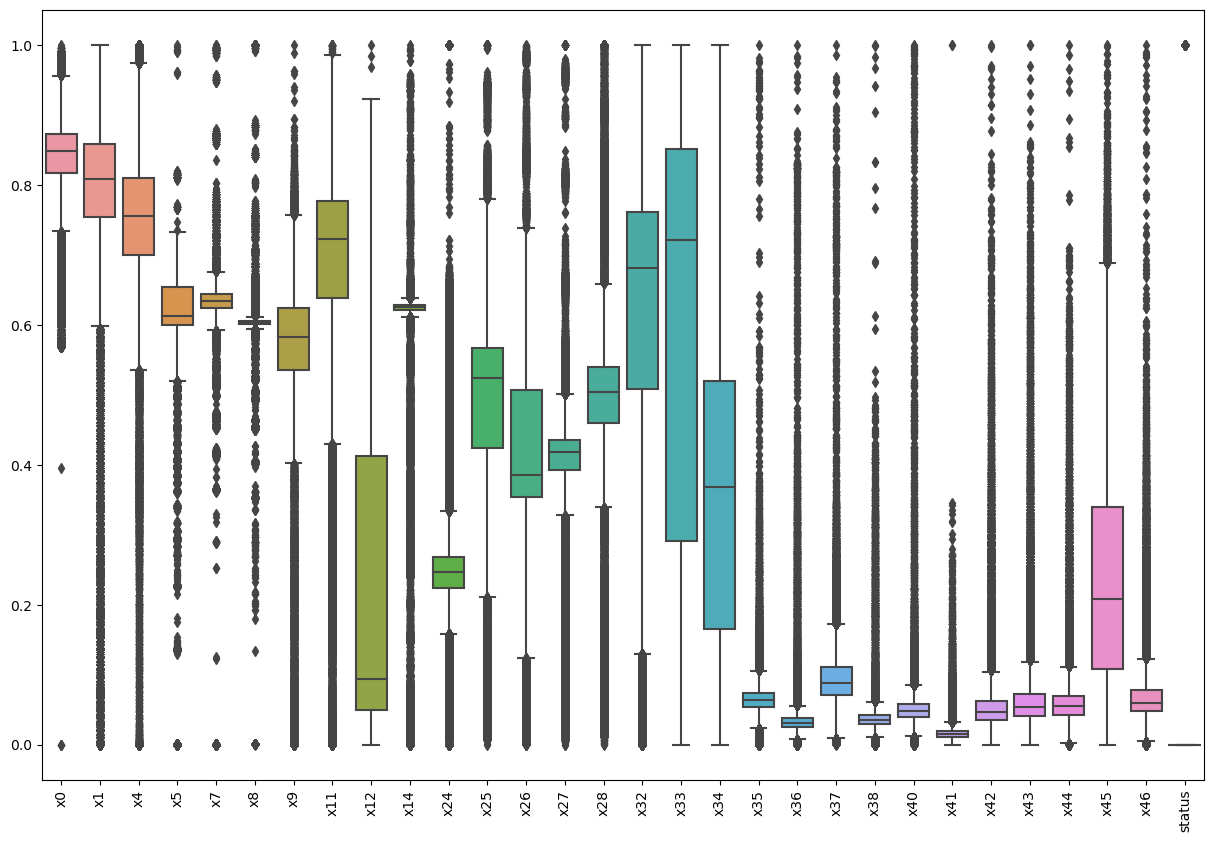

In [21]:
# Plot a boxplot of the data after feature selection
plt.figure(figsize=(15,10))
sns.boxplot(data=after_drop_df)
plt.xticks(rotation=90)
plt.show()

## Preparation for train and test

In [22]:
# Set the size of the sectors and initialize variables
sector_1 = 30
sector_2 = 60 * 6
df_len = df.shape[0]
number_of_pairs = 2000
working_area = df_len - (sector_2 + sector_1)
scaled_df = MinMaxScaler().fit_transform(after_drop_df[after_drop_df.columns[:-1]])

# Initialize the pairs list and counter
pairs = list()
count = 0

# Generate the pairs
while len(pairs) != number_of_pairs:
    # Find a start position with a pump off status
    pump_status = False
    while not pump_status:
        start = rd(0, working_area)
        stop = start + sector_1
        if status_chacker(df, start, stop) == 0:
            pump_status = True
    
    # Extract the detected vector and determine the vector status
    detected_vector_hour = scaled_df[start:start + sector_1].flatten()
    vector_status = status_chacker(df, start - sector_2, start + sector_2)
    
    # Add the pair to the list if the conditions are matching
    if vector_status == 1:
        count += 1
        pairs.append((detected_vector_hour, vector_status))
    if (vector_status == 0) and (count > 400):
        pairs.append((detected_vector_hour, vector_status))

In [23]:
# Create an empty matrix with the appropriate number of rows and columns
pairs_shape = pairs[0][0].shape[0]
num_rows = number_of_pairs
num_cols = pairs_shape + 1
matrix = np.zeros((num_rows, num_cols))
print("Shape of matrix:", matrix.shape)

# Fill the matrix with the data from the pairs
for i in range(num_rows):
    X, y = pairs[i]
    matrix[i, 0:pairs_shape] = X
    matrix[i, pairs_shape] = y

Shape of matrix: (2000, 871)


In [24]:
# Create a pandas dataframe from the matrix variable
matrix = pd.DataFrame(matrix)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    matrix[matrix.columns[:-1]],
    matrix[matrix.columns[-1]],
    test_size=0.2,
    random_state=0
)

## ML training section

In [25]:
# This dictionary will store the evaluation results of different machine learning algorithms
evaluating_dict = {
    'algorithm_name':[],
    'train_score_roc_auc':[],
    'train_precision_score':[], 
    'test_score_roc_auc':[], 
    'test_precision_score':[],
    'best_params':[] 
}

In [26]:
# Define a dictionary containing hyperparameters for each algorithm
param_dict = {
    'GradientBoostingClassifier': {
        'learning_rate': [0.1, 0.01, 0.001],  # The step size shrinkage used in update to prevent overfitting
        'min_samples_split': [2, 4, 6],  # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
        'n_estimators': [20, 50, 100],  # The number of trees in the forest
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
    },
    'RandomForestClassifier': {
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5], # The minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'], # The function to measure the quality of a split
        'n_estimators': [20, 50, 100], # The number of trees in the forest
        'max_depth': [2, 4, 6], # The maximum depth of the tree
    },
    'DecisionTreeClassifier': {
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5],  # The minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split.
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
    },
    'KNeighborsClassifier': {
        'weights': ['uniform', 'distance'],  # Weight function used in prediction
        'n_neighbors': [1, 3, 5],  # Number of neighbors to use
        'p': [1, 2],  # Power parameter for the Minkowski metric
    },
    'XGBClassifier': {
        'colsample_bytree': [0.5, 0.8, 1],  # Subsample ratio of columns when constructing each tree
        'learning_rate': [0.1, 0.01, 0.001],  # Boosting learning rate (xgb’s “eta”)
        'subsample': [0.5, 0.8, 1],  # Subsample ratio of the training instances
        'n_estimators': [20, 50, 100],  # Number of trees in the forest
        'max_depth': [2, 4, 6],  # Maximum depth of a tree
    },
    'GaussianNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7],  # Portion of the largest variance of all features that is added to variances for calculation stability
    },
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf'],  # Specifies the kernel type to be used in the algorithm
        'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
        'degree': [2, 3, 4],  # Degree of the polynomial kernel function
        'C': [0.1, 1, 10],  # Penalty parameter C of the error term
    }
}

In [27]:
# Define a dictionary containing algorithm name and algorithm class as value
algorithm_dict = {
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'XGBClassifier':XGBClassifier(),
    'GaussianNB':GaussianNB(),
    'SVC':SVC(),
}

In [28]:
# Training section
for number,(algorithm_name,algorithm) in enumerate(algorithm_dict.items()):
    print(f'Step : #{number}\nAlgorithm : {algorithm_name}')
    
    # Perform a grid search using the GridSearchCV function
    grid_search = GridSearchCV(
        estimator=algorithm,
        param_grid=param_dict[algorithm_name],
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        error_score='raise'
    )
    
    # Fitting section
    print('Fitting model')
    grid_search.fit(X_train,y_train)
    
    # Registration section
    print('Registrating score')    
    registrate_score(
        evaluating_dict,
        grid_search,
        X_train,y_train,
        X_test,y_test,
        algorithm_name,
    )
    
    print('------')

Step : #0
Algorithm : GradientBoostingClassifier
Fitting model
Registrating score
------
Step : #1
Algorithm : DecisionTreeClassifier
Fitting model
Registrating score
------
Step : #2
Algorithm : RandomForestClassifier
Fitting model
Registrating score
------
Step : #3
Algorithm : KNeighborsClassifier
Fitting model
Registrating score
------
Step : #4
Algorithm : XGBClassifier
Fitting model
Registrating score
------
Step : #5
Algorithm : GaussianNB
Fitting model
Registrating score
------
Step : #6
Algorithm : SVC
Fitting model
Registrating score
------


## ANN training section

In [29]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=10
)
checkpointer = ModelCheckpoint(
    filepath='Water pump maintenance - break prediction_chackpoint.h5', 
    save_best_only=True,
    monitor='val_accuracy'
)

In [31]:
# Define the possible values for the optimizer , learning rate and other hyperparameters
param_grid = {
    'model__optimizer': [Adam, SGD, RMSprop, Adamax],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.0, 0.2, 0.4],
    'model__batch_size': [100,500], 
    'model__units':[200,300,400],
    'model__epochs': [20,50]
}

# Use KerasClassifier to define the model and GridSearchCV to tune the hyperparameters
model = KerasClassifier(
    model = create_model,
    verbose = 0,
    validation_split = 0.2,
    validation_batch_size = 50,
    callbacks=early_stopping
)

grid_search = GridSearchCV(
    model, 
    param_grid,
    cv=5, 
    n_jobs=-1,
    error_score='raise',
    scoring='roc_auc'
)

# Fitting grid_search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print(grid_search.best_params_)

{'model__batch_size': 100, 'model__dropout_rate': 0.0, 'model__epochs': 50, 'model__learning_rate': 0.001, 'model__optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'model__units': 400}


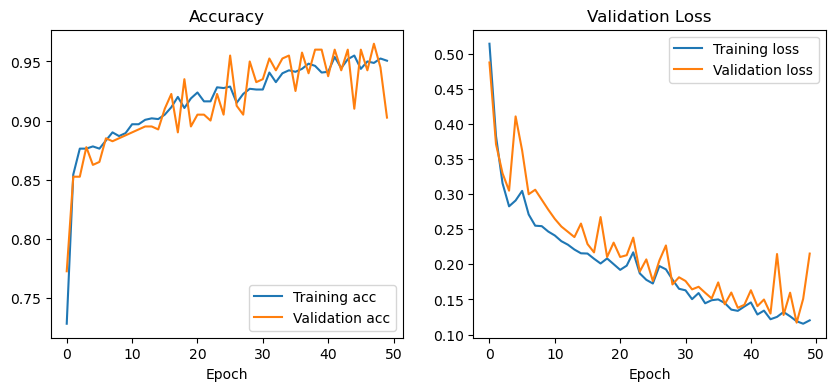

In [40]:
# Define model
model = create_model(
    learning_rate=grid_search.best_params_['model__learning_rate'],
    dropout_rate=grid_search.best_params_['model__dropout_rate'],
    batch_size=grid_search.best_params_['model__batch_size'],
    optimizer=grid_search.best_params_['model__optimizer'],
    epochs=grid_search.best_params_['model__epochs'],
    units=grid_search.best_params_['model__units'],
)

# Fitting model
history = model.fit(
    X_train, 
    y_train,
    batch_size = 200,
    epochs = 50,
    verbose=0,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping, checkpointer]
)

# Evaluating plots
fig, axs = plt.subplots(1, 2,figsize=(10,4))

# Get the length of the data
history_len = len(history.history['accuracy'])

# Create a dictionary to store the plots, labels and titles
plots = {
    'acc':['accuracy','val_accuracy','Accuracy'],
    'loss':['loss','val_loss','Validation Loss'],
}

# Iterate over the dictionary and plot the data
for i, (key,value) in enumerate(plots.items()):
    # Plot the training and validation data
    axs[i].plot(range(history_len), history.history[value[0]],label = f'Training {key}')
    axs[i].plot(range(history_len), history.history[value[1]],label = f'Validation {key}')
    # Add the legend
    axs[i].legend()
    # Set the title
    axs[i].set_title(value[2])
    # Set the x-axis label
    axs[i].set_xlabel('Epoch')
# Show the plot
plt.show()

# Registration scores
registrate_score(
    evaluating_dict,
    grid_search,
    X_train,y_train,
    X_test,y_test,
    'ANN_model',
    model,
)

In [41]:
# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}')

# Saving model
model.save('Water pump maintenance - break prediction_best_model.h5')

Test loss: 0.2153731733560562
Test accuracy: 0.9024999737739563


13/13 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       302
         1.0       0.97      0.62      0.76        98

    accuracy                           0.90       400
   macro avg       0.93      0.81      0.85       400
weighted avg       0.91      0.90      0.89       400



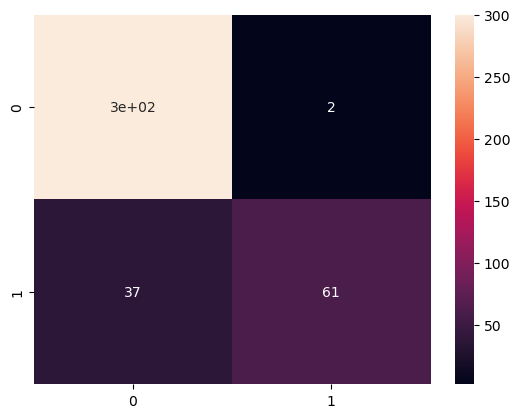

In [42]:
# Confusion Matrix and Classification Report of ann model
y_pred = (model.predict(X_test) > 0.5)

sns.heatmap(
    confusion_matrix(y_test,y_pred),
    annot=True
)

print(classification_report(y_test,y_pred))

## Evaluating section

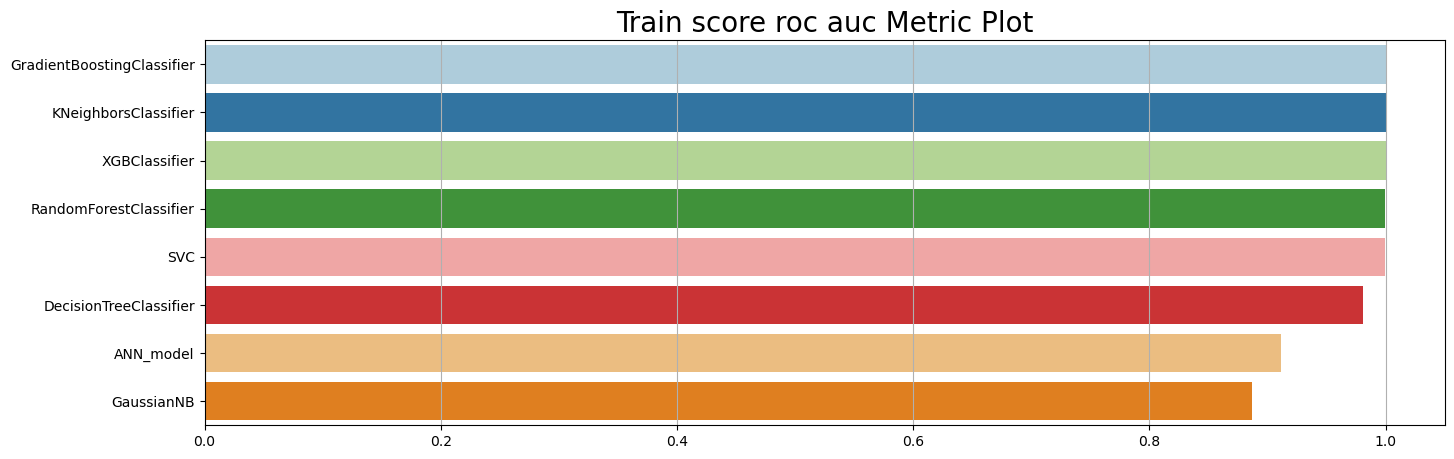

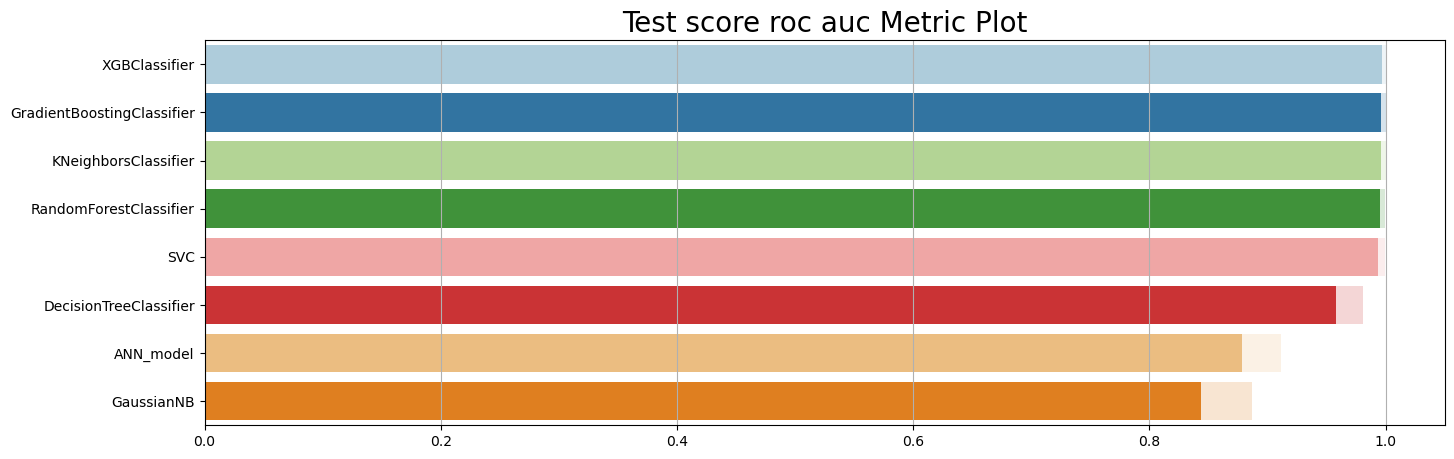

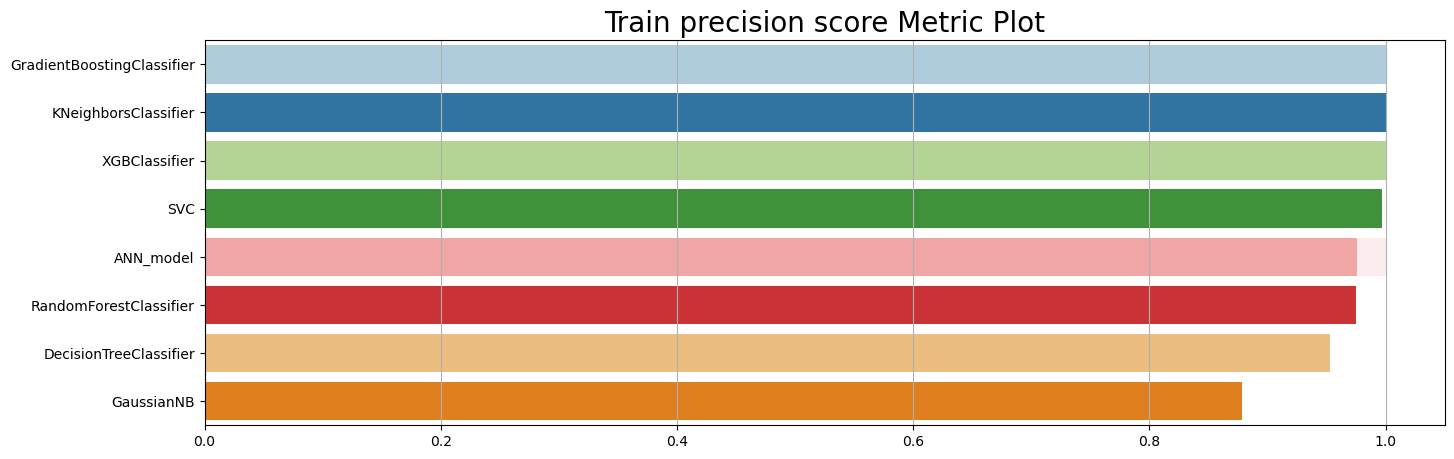

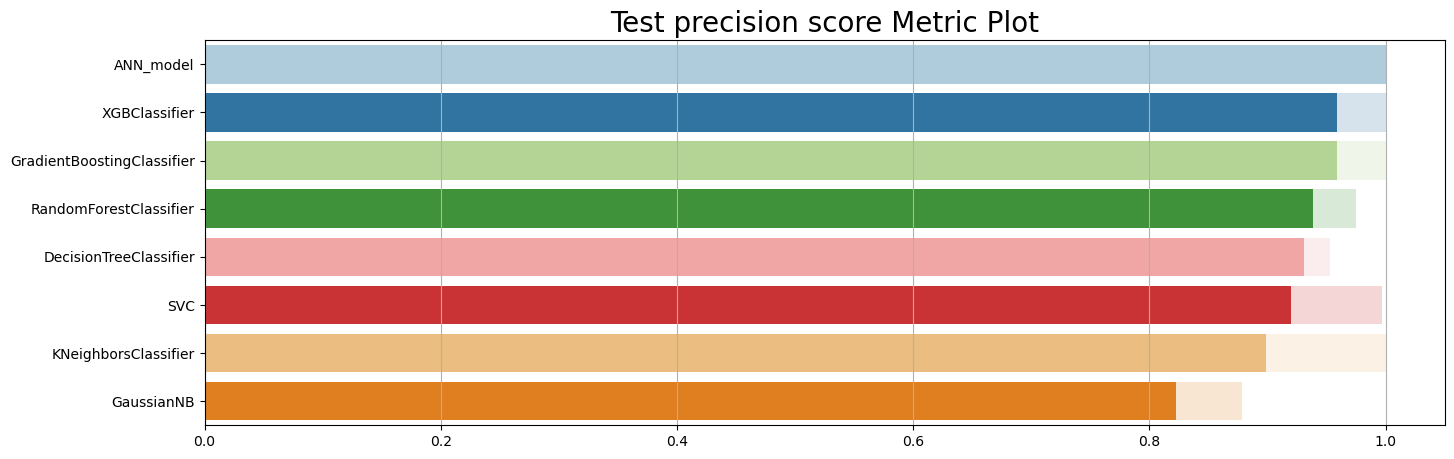

In [43]:
for metric in ['train_score_roc_auc','test_score_roc_auc','train_precision_score','test_precision_score']:
    eval_plot(evaluating_dict,metric)

- <b>Conclusion</b></font>

    - To sum up, I found working on this project to be incredibly engaging. Through it, I gained knowledge about artificial neural networks, including their layers and neuron functionality. Additionally, I integrated machine learning (ML) into the project, which yielded positive outcomes, highlighting that neural networks are not always the optimal solution for particular tasks.
    - To overcome the issue of non-uniform distribution, I segmented the data into time series. Typically, the final dataset was composed of 95% "Normal" state rows and only 5% "broken" state rows. This uneven distribution often resulted in overfitting or underfitting, depending on the dataset split. However, by modifying the time series construction approach, I was able to tackle this problem.
    <br>
    - Furthermore, utilizing GridSearchCV, I tried to find the optimal parameters for neural network.